In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc,
                             confusion_matrix, ConfusionMatrixDisplay)


In [2]:
# 1. Load and Prepare the Dataset
df = pd.read_csv("diabetes.csv")  


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


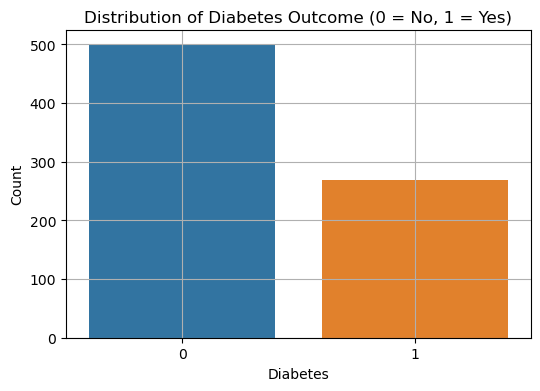

In [6]:
# 1. Target variable distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', data=df)
plt.title("Distribution of Diabetes Outcome (0 = No, 1 = Yes)")
plt.xlabel("Diabetes")
plt.ylabel("Count")
plt.grid(True)
plt.show()


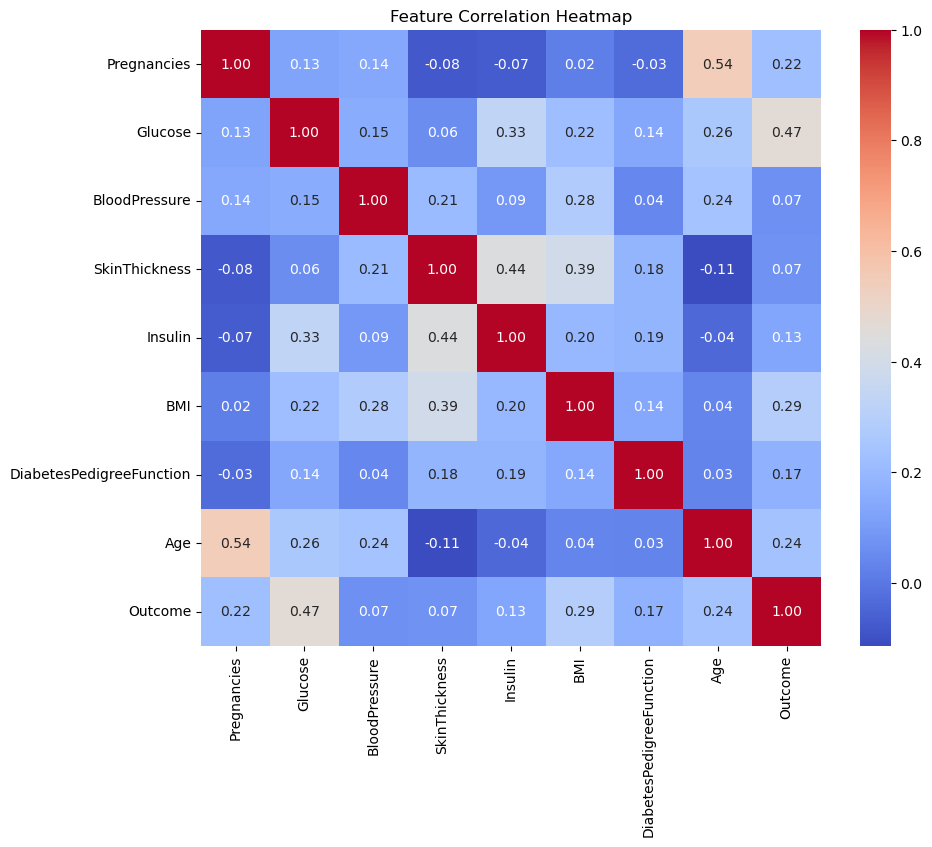

In [7]:
# 2. Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
# 3. Boxplots for selected features
important_features = ['Glucose', 'BMI', 'Age', 'Insulin']

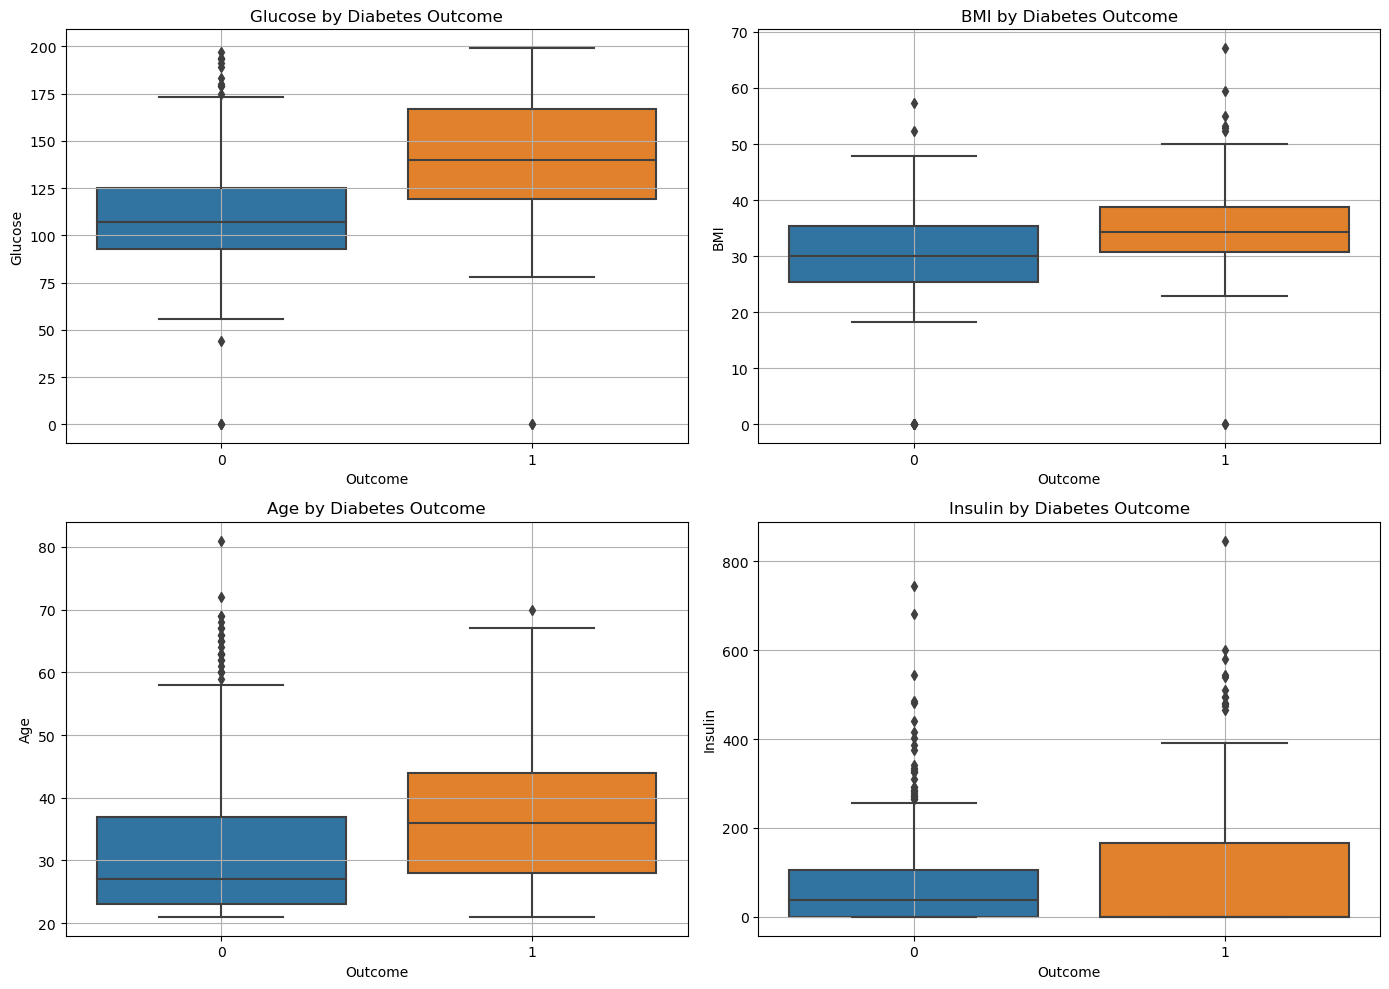

In [9]:
plt.figure(figsize=(14,10))
for i, col in enumerate(important_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(f'{col} by Diabetes Outcome')
    plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Replace invalid zeroes with NaN for selected features
cols_with_zero_invalid = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_with_zero_invalid] = df[cols_with_zero_invalid].replace(0, np.nan)


In [11]:
# Impute missing values with median
df[cols_with_zero_invalid] = df[cols_with_zero_invalid].fillna(df[cols_with_zero_invalid].median())


In [12]:
# Split features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [14]:
# 2. Define and Train All Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', n_estimators=50, random_state=42)
}

In [15]:
# Train and predict
results = []
probabilities = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    probabilities[name] = y_prob

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    })

In [16]:
# Show results
results_df = pd.DataFrame(results).sort_values(by="ROC AUC", ascending=False)
print("\nModel Performance:\n", results_df)



Model Performance:
                  Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
1        Random Forest  0.740260   0.631579  0.654545  0.642857  0.833425
0  Logistic Regression  0.753247   0.666667  0.618182  0.641509  0.822957
2                  SVM  0.746753   0.666667  0.581818  0.621359  0.807163
3              XGBoost  0.720779   0.593750  0.690909  0.638655  0.778696



🔍 Confusion Matrix: Logistic Regression


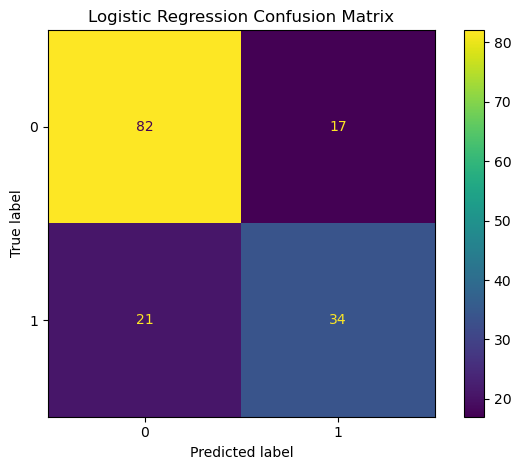


🔍 Confusion Matrix: Random Forest


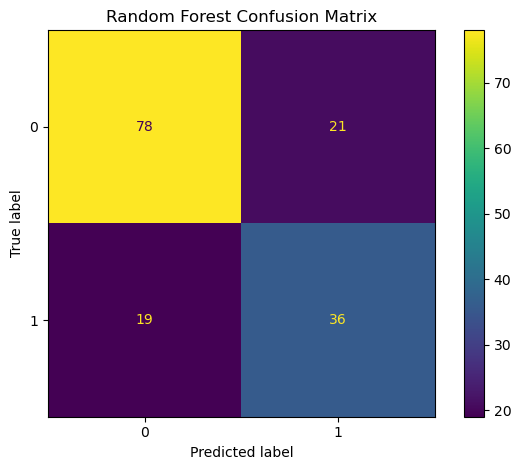


🔍 Confusion Matrix: SVM


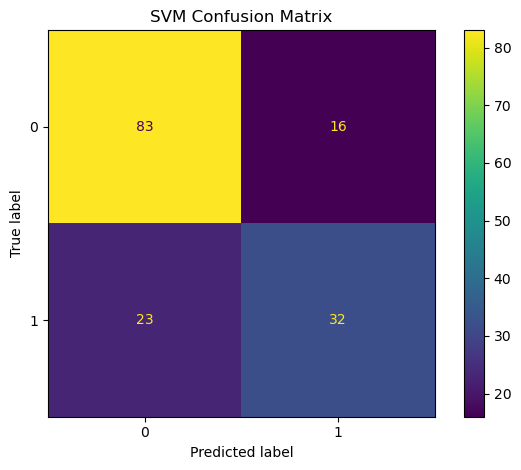


🔍 Confusion Matrix: XGBoost


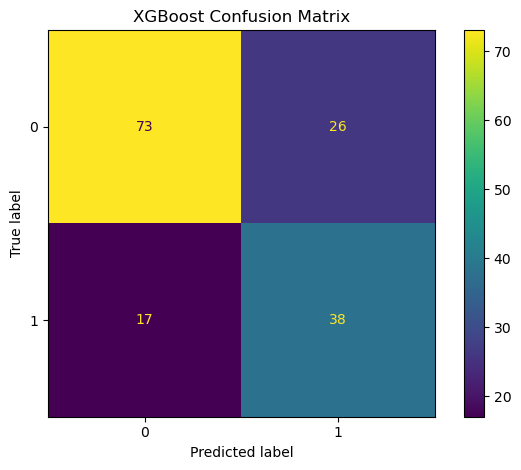

In [17]:
# 3. Confusion Matrices
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n🔍 Confusion Matrix: {name}")
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title(f"{name} Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

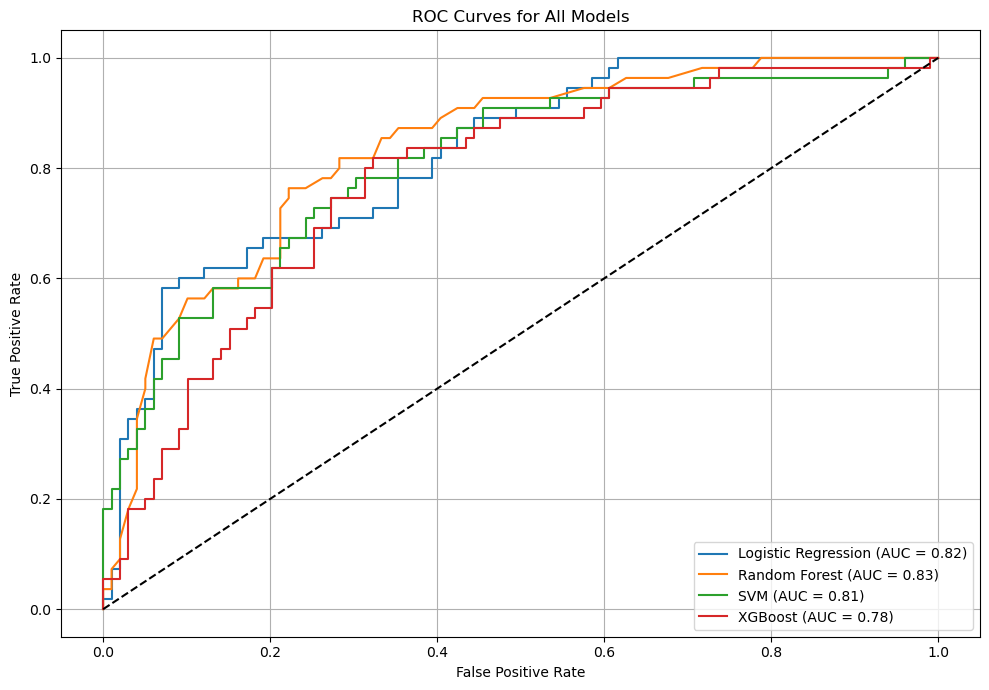

In [18]:
# 4. Plot ROC Curves
plt.figure(figsize=(10, 7))
for name, y_prob in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5,
                           scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [20]:
# Evaluate tuned RF
y_pred_best_rf = best_rf.predict(X_test)
y_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]
print("\nTuned RF Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("Precision:", precision_score(y_test, y_pred_best_rf))
print("Recall:", recall_score(y_test, y_pred_best_rf))
print("F1 Score:", f1_score(y_test, y_pred_best_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_best_rf))


Tuned RF Performance:
Accuracy: 0.7467532467532467
Precision: 0.6538461538461539
Recall: 0.6181818181818182
F1 Score: 0.6355140186915887
ROC AUC: 0.8356290174471992


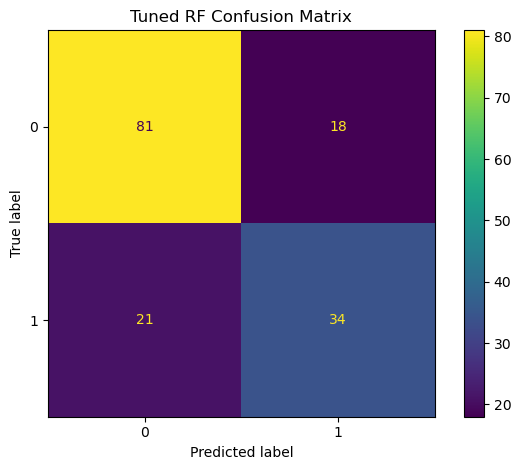

In [21]:
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_best_rf)).plot()
plt.title("Tuned RF Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

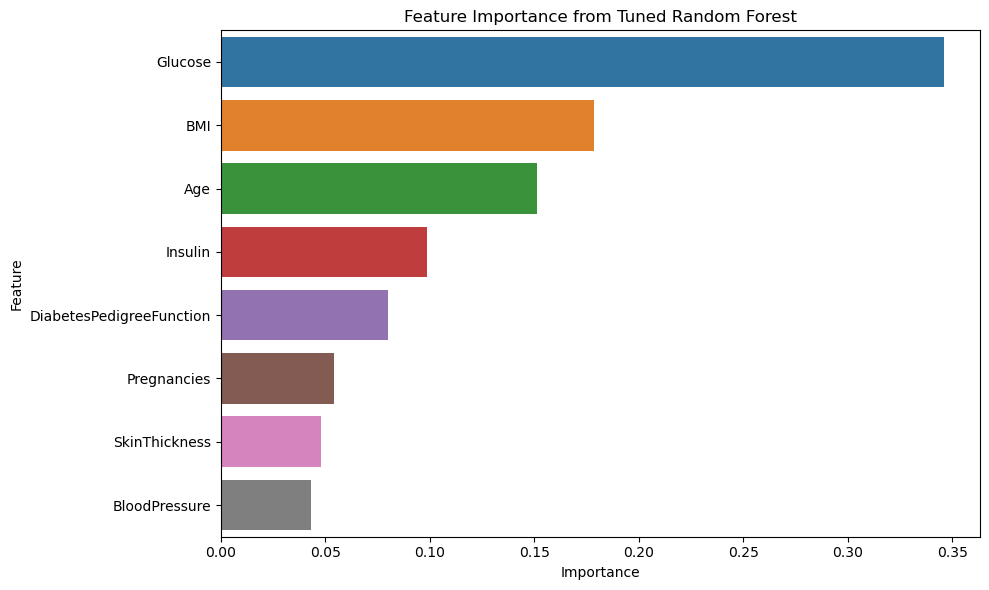

In [22]:
# Feature Importance
importances = best_rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance from Tuned Random Forest")
plt.tight_layout()
plt.show()